## Imports

In [26]:
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC

# Sklearn imports for processing and evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import median_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from numpy import argmax
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# Plotting
from matplotlib import pyplot as plt

# Misc
import time
from tqdm import tqdm




## Load data

In [47]:
x_train = np.loadtxt('X_train.txt')
y_train = np.loadtxt('Y_train.txt')

x_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('Y_test.txt')

## Combined data

In [48]:
combined_x = np.concatenate((x_train, x_test))
combined_y = np.concatenate((y_train, y_test))

assert combined_x.shape[0] == x_train.shape[0] + x_test.shape[0]
assert combined_y.shape[0] == y_train.shape[0] + y_test.shape[0]

## K-fold

In [5]:
def do_kfold_pca(model, x_data, y_data, features='all', folds=10):
     
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(x_data))):    
        
        # Do PCA
        features = x_data.shape[1] if(features == 'all') else features
        pca = PCA(n_components=features)
        scalar = StandardScaler().fit(x_data[train_idx])
        standardized = scalar.transform(x_data[train_idx])
        transformed = pca.fit_transform(standardized)
        
        # Fit and time model
        start = time.time()
        model.fit(transformed, y_data[train_idx])
        fit_times.append(time.time() - start)
        
        # Transform test data and evaluate
        test_transform = np.dot(scalar.transform(x_data[test_idx]), pca.components_.T)
        preds = model.predict(test_transform)
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} FEATURES PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(features, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

## Plot results

In [6]:
def plot_results(results, times):
    # Get means
    acc_mean = np.mean(results, axis=1)
    acc_stds = np.std(results, axis=1)
    time_mean = np.mean(times, axis=1)
    time_stds = np.std(times, axis=1)

    # Plot prediction accuracies
    fig, ax = plt.subplots()
    ax.plot(num_features, acc_mean)
    ax.fill_between(num_features, acc_mean+acc_stds, acc_mean-acc_stds, alpha=0.3)
    ax.set(title="Prediction Accuracies", xlabel="Number of PCA Components", ylabel="Prediction Acciracy")
    plt.show()

    # Plot timing
    fig, ax = plt.subplots()
    ax.plot(num_features, time_mean)
    ax.fill_between(num_features, time_mean+time_stds, time_mean-time_stds, alpha=0.3)
    ax.set(title="Training Time", xlabel="Number of PCA Components", ylabel="Time (s)")
    plt.show()

## Gradient Boosting Classifier: Baseline model

In [8]:
pred_accuracy, fit_times = do_kfold_pca(GradientBoostingClassifier(n_estimators=10), combined_x, combined_y, features=561)
pred_accuracy

10it [30:00, 180.05s/it]

561 FEATURES PREDICTION ACCURACY: 0.800 $\pm$ 0.034


[0.8262135922330097,
 0.8300970873786407,
 0.7601941747572816,
 0.7611650485436893,
 0.7970873786407767,
 0.7970873786407767,
 0.8533980582524272,
 0.8019417475728156,
 0.8300970873786407,
 0.7414965986394558]

In [13]:
Acc_GB = np.mean(pred_accuracy)
time_GB = np.mean(fit_times)

## RandomForestClassifier: baseline model

In [14]:
pred_accuracyRF, fit_timesRF = do_kfold_pca(RandomForestClassifier(n_estimators=10), combined_x, combined_y, features=561)

10it [00:52,  5.27s/it]

561 FEATURES PREDICTION ACCURACY: 0.733 $\pm$ 0.018


In [15]:
Acc_RF = np.mean(pred_accuracyRF)
time_RF = np.mean(fit_timesRF)

## Logistic regression: baseline model

In [18]:
pred_accuracyLR, fit_timesLR = do_kfold_pca(LogisticRegression(multi_class='ovr', solver='liblinear'), combined_x, combined_y, features=561)

10it [03:34, 21.40s/it]

561 FEATURES PREDICTION ACCURACY: 0.962 $\pm$ 0.026


In [19]:
Acc_LR = np.mean(pred_accuracyLR)
time_LR = np.mean(fit_timesLR)

## SVM: Baseline Model

In [24]:
pred_accuracySVM, fit_timesSVM = do_kfold_pca(svm.SVC(kernel='linear', C=1), combined_x, combined_y, features=561)

10it [00:51,  5.13s/it]

561 FEATURES PREDICTION ACCURACY: 0.958 $\pm$ 0.020


In [25]:
Acc_SVM = np.mean(pred_accuracySVM)
time_SVM = np.mean(fit_timesSVM)

In [33]:
pred_accuracySVMP, fit_timesSVMP = do_kfold_pca(svm.SVC(kernel='poly', C=1), combined_x, combined_y, features=561)

10it [01:52, 11.27s/it]

561 FEATURES PREDICTION ACCURACY: 0.938 $\pm$ 0.022


In [34]:
Acc_SVMP = np.mean(pred_accuracySVMP)
time_SVMP = np.mean(fit_timesSVMP)

## Neural Network: baseline model

In [49]:
def do_kfoldNN(x_data, y_data, features='all', folds=10):
    start = time.time()
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(x_data))):    
        
        # Do PCA
        features = x_data.shape[1] if(features == 'all') else features
        pca = PCA(n_components=features)
        scalar = StandardScaler().fit(x_data[train_idx])
        standardized = scalar.transform(x_data[train_idx])
        transformed = pca.fit_transform(standardized)
        
        # Fit and time model
        
        x = x_data[train_idx].astype('float32')
        n_features = x_data[train_idx].shape[1]
        k1 = transformed.shape[1]
        print(k1)
        model = Sequential()
        model.add(Dense(k1, activation='relu', kernel_initializer='he_normal', input_shape=(k1,)))
        model.add(Dense(384, activation='relu',  kernel_initializer='he_normal'))
        model.add(Dense(6,activation='softmax'))
        
        optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
        
        model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(transformed, y_data[train_idx], batch_size = 30, epochs = 50)
        # Transform test data and evaluate
        test_transform = np.dot(scalar.transform(x_data[test_idx]), pca.components_.T)
        preds = model.predict(test_transform)
        #print(preds)
        #print(y_data[test_idx])
        loss, score = model.evaluate(test_transform, y_data[test_idx], verbose=0)
        #score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        fit_times.append(time.time() - start)
        
    print(r"{0} FEATURES PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(features, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

In [50]:
for i in range (0,len(combined_y)):
    combined_y[i] = combined_y[i]-1

In [51]:
pred_accuracyNN, fit_timesNN = do_kfoldNN(combined_x, combined_y, features=561)

0it [00:00, ?it/s]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1489 - accuracy: 0.9456
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0551 - accuracy: 0.9845
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0171 - accuracy: 0.9937
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0090 - accuracy: 0.9972
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 0.9995
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 8.1509e-04 - accuracy: 1.0000
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 1.9044e-04 - accuracy: 1.0000
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 9.9418e-05 - accuracy: 1.0000
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 7.2080e-05 - accuracy: 1.0000
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 5.652

1it [01:35, 95.29s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1651 - accuracy: 0.9376
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0319 - accuracy: 0.9886
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0180 - accuracy: 0.9940
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 9.1442e-04 - accuracy: 1.0000
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 3.1006e-04 - accuracy: 1.0000
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 1.4366e-04 - accuracy: 1.0000
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 8.9923e-05 - accuracy: 1.0000
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 6.7975e-05 - accuracy: 1.0000
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 5

2it [03:10, 95.42s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1594 - accuracy: 0.9425
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0350 - accuracy: 0.9859
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0162 - accuracy: 0.9945
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0262 - accuracy: 0.9914
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.9963
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0145 - accuracy: 0.9957
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0277 - accuracy: 0.9933
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 0.9991
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 5.1637e-04 - accuracy

3it [04:40, 92.68s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1559 - accuracy: 0.9430
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0324 - accuracy: 0.9879
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0140 - accuracy: 0.9949
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0350 - accuracy: 0.9919
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0061 - accuracy: 0.9987
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0043 - accuracy: 0.9986
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0135 - accuracy: 0.9958
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0107 - accuracy: 0.9971
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0180 - accuracy: 0.9969
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 8.5714e-04 - accuracy

4it [06:09, 91.25s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1512 - accuracy: 0.9439
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0430 - accuracy: 0.9848
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0274 - accuracy: 0.9919
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0157 - accuracy: 0.9951
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0141 - accuracy: 0.9951
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0114 - accuracy: 0.9961
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0060 - accuracy: 0.9982
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 1.2224e-04 - accuracy

5it [07:39, 90.95s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1701 - accuracy: 0.9409
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0450 - accuracy: 0.9861
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0174 - accuracy: 0.9944
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0311 - accuracy: 0.9928
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0068 - accuracy: 0.9985
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0063 - accuracy: 0.9983
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 7.8250e-04 - accuracy: 0.9999
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 1.2458e-04 - accuracy: 1.0000
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 6.7053e-05 - accuracy: 1.0000
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 4.8984e-0

6it [09:16, 93.02s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1633 - accuracy: 0.9401
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0399 - accuracy: 0.9867
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0230 - accuracy: 0.9922
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0288 - accuracy: 0.9933
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0093 - accuracy: 0.9974
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0039 - accuracy: 0.9988
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.9969
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0132 - accuracy: 0.9956
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0111 - accuracy: 0.

7it [10:46, 91.99s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1630 - accuracy: 0.9422
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0388 - accuracy: 0.9869
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0138 - accuracy: 0.9947
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0088 - accuracy: 0.9972
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0069 - accuracy: 0.9975
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0070 - accuracy: 0.9974
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0090 - accuracy: 0.9964
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0188 - accuracy: 0.9954
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0070 - accuracy: 0.9976
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0132 - accuracy: 0.

8it [12:18, 92.05s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1496 - accuracy: 0.9455
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0413 - accuracy: 0.9868
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0204 - accuracy: 0.9942
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0209 - accuracy: 0.9935
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0191 - accuracy: 0.9961
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.9956
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0072 - accuracy: 0.9975
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 8.9715e-04 - accuracy: 0.9999
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 1.2473e-04 - accuracy: 1.0000
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 5.9042e-05 - 

9it [13:52, 92.65s/it]

561
Epoch 1/50
309/309 [==============================] - 2s 6ms/step - loss: 0.1551 - accuracy: 0.9427
Epoch 2/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0530 - accuracy: 0.9831
Epoch 3/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0264 - accuracy: 0.9912
Epoch 4/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0104 - accuracy: 0.9962
Epoch 5/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.9994
Epoch 6/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0017 - accuracy: 0.9997
Epoch 7/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0110 - accuracy: 0.9959
Epoch 8/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0107 - accuracy: 0.9970
Epoch 9/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0093 - accuracy: 0.9965
Epoch 10/50
309/309 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 0.

10it [15:25, 92.50s/it]

561 FEATURES PREDICTION ACCURACY: 0.962 $\pm$ 0.021


In [52]:
Acc_NN = np.mean(pred_accuracyNN)
time_NN = np.mean(fit_timesNN)

## Comparison of all models

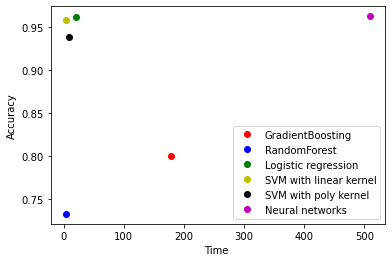

In [53]:

plt.plot(time_GB,Acc_GB, 'ro', label = 'GradientBoosting')
plt.plot(time_RF,Acc_RF, 'bo', label = 'RandomForest')
plt.plot(time_LR,Acc_LR, 'go', label = 'Logistic regression')
plt.plot(time_SVM,Acc_SVM, 'yo', label = 'SVM with linear kernel')
plt.plot(time_SVMP,Acc_SVMP, 'ko', label = 'SVM with poly kernel')
plt.plot(time_NN,Acc_NN, 'mo', label = 'Neural networks')
plt.xlabel('Time ')
plt.ylabel('Accuracy')
plt.legend();
